In [1]:
library(readr)
library(vars)
library(forecast)
library(quantmod)

Loading required package: MASS
Loading required package: strucchange
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Loading required package: sandwich
Loading required package: urca
Loading required package: lmtest
Loading required package: xts
Loading required package: TTR
Version 0.4-0 included new data defaults. See ?getSymbols.


In [2]:
sg.data <- read_csv("../data/stock_gdp.csv")
def.par <- par(no.readonly = TRUE)

Parsed with column specification:
cols(
  date = col_character(),
  gdp = col_double(),
  gdp_rate = col_double(),
  year = col_double(),
  close = col_double(),
  trade_times = col_double(),
  trade_money = col_double()
)


In [3]:
tail(sg.data)

date,gdp,gdp_rate,year,close,trade_times,trade_money
2013Q3,152905.3,0.10303617,2013,2085.305,11959309544,100387124800
2013Q4,168625.1,0.10596390,2013,2169.776,10879560013,95360694574
2014Q1,140618.3,0.08378845,2014,2051.636,10220302359,86478210013
2014Q2,156461.3,0.08678586,2014,2049.465,8477278433,68661667068
2014Q3,165711.9,0.08375511,2014,2203.498,16178101255,134330501971
2014Q4,181182.5,0.07446934,2014,2641.362,34052695423,319529243631


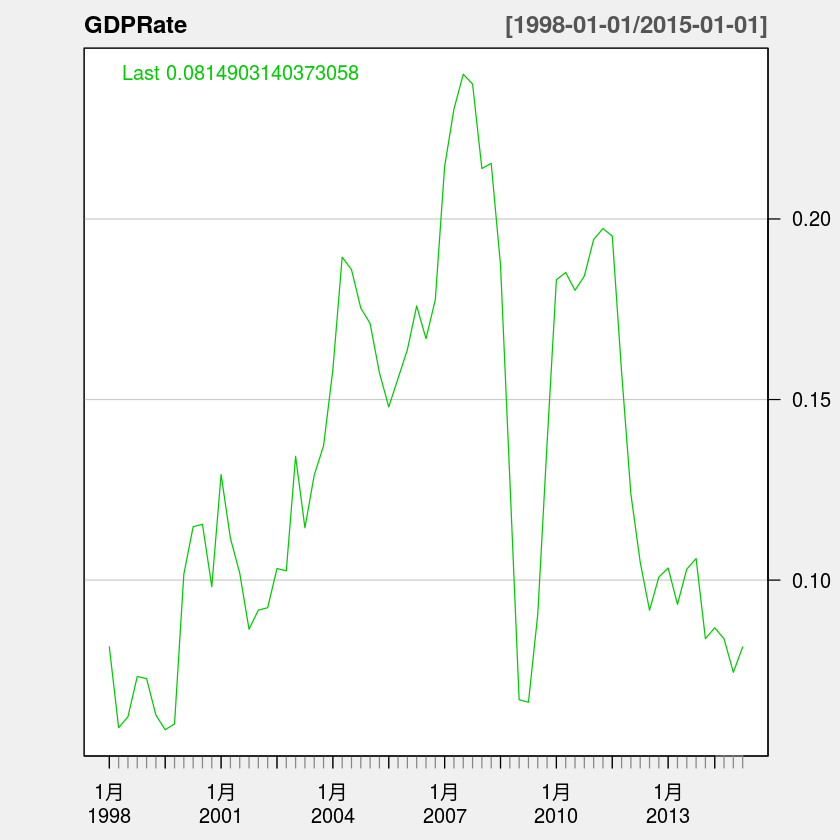

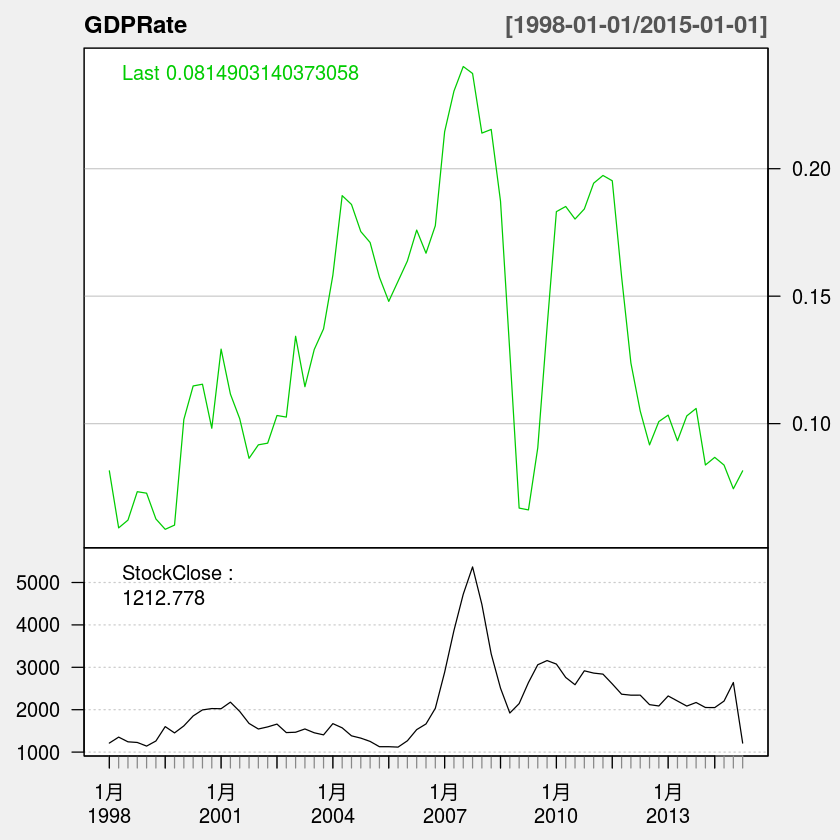

In [28]:
GDPRate <- ts(sg.data$gdp_rate, start=1998, end=2015, frequency=4)
StockClose <- ts(sg.data$close, start=1998, end=2015, frequency=4)
chartSeries(GDPRate, theme = chartTheme("white"))
addTA(StockClose)

In [8]:
# ADF检验
library(aTSA)
stationary.test(diff(sg.data$close), method = "adf")
stationary.test(diff(sg.data$trade_times), method = "adf")

Augmented Dickey-Fuller Test 
alternative: stationary 
 
Type 1: no drift no trend 
     lag   ADF p.value
[1,]   0 -3.81    0.01
[2,]   1 -5.03    0.01
[3,]   2 -4.95    0.01
[4,]   3 -5.58    0.01
Type 2: with drift no trend 
     lag   ADF p.value
[1,]   0 -3.79    0.01
[2,]   1 -5.02    0.01
[3,]   2 -4.94    0.01
[4,]   3 -5.58    0.01
Type 3: with drift and trend 
     lag   ADF p.value
[1,]   0 -3.74  0.0279
[2,]   1 -4.97  0.0100
[3,]   2 -4.89  0.0100
[4,]   3 -5.54  0.0100
---- 
Note: in fact, p.value = 0.01 means p.value <= 0.01 
Augmented Dickey-Fuller Test 
alternative: stationary 
 
Type 1: no drift no trend 
     lag   ADF p.value
[1,]   0 -2.88  0.0100
[2,]   1 -3.73  0.0100
[3,]   2 -2.91  0.0100
[4,]   3 -2.43  0.0174
Type 2: with drift no trend 
     lag   ADF p.value
[1,]   0 -2.99  0.0440
[2,]   1 -3.88  0.0100
[3,]   2 -3.10  0.0343
[4,]   3 -2.67  0.0889
Type 3: with drift and trend 
     lag   ADF p.value
[1,]   0 -3.13  0.1162
[2,]   1 -3.97  0.0168
[3,]   2 -3

In [9]:
sg.data['Dclose'] <- c(140.53547235577, diff(sg.data$close))
sg.data['Dtrade_times'] <- c(450000355.048077, diff(sg.data$trade_times))

In [10]:
sub_sg <- subset(sg.data, select = c("Dclose", "Dtrade_times"))
VARselect(sub_sg, lag.max=4, type='const')
var.2c <- VAR(sub_sg, p=1, type = "const")
# summary(var.2c)
# plot(var.2c)

,1,2,3,4
AIC(n),5.466385e+01,5.454749e+01,5.458324e+01,5.464253e+01
HQ(n),5.474358e+01,5.468038e+01,5.476929e+01,5.488173e+01
SC(n),5.486624e+01,5.488481e+01,5.505550e+01,5.524972e+01
FPE(n),5.498779e+23,4.897226e+23,5.081163e+23,5.402299e+23


### 因果检验

Causality Analysis(Using the vars package Dr. Bernhard Pfaff, Kronberg im Taunus)

>Often researchers are interested in the detection of causalities between
variables. The most common one is the Granger-Causality test (Granger
1969). Incidentally, this test is not suited to test causal relationships
in the strict sense, because the possibility of a post hoc ergo propter hoc
fallacy cannot be excluded. This is true for any so called “causality test” in
econometrics. It is therefore common practice to say that variables x does
granger-cause variable y if variable x helps to predict variable y. Aside
of this test, within the function causality() a Wald-type instantaneous
causality test is implemented too. It is characterized by testing for nonzero
correlation between the error processes of the cause and effect variables.

其实严格意义上Granger-Causality test不能真正反映因果关系（格兰杰因果只检验了事件先后发生的关系，不代表真实的因果），因为在其中post hoc ergo propter hoc fallacy(后此谬误)不能被排除。所以我们另外通过Wald-type instantaneous causality test进一步确定trade_times与close price的因果关系，作为我们初步的结果。

In [11]:
causality(var.2c, cause = "Dclose")
causality(var.2c, cause = "Dtrade_times")

# plot(irf(var.2c, impulse="close"))
# plot(irf(var.2c, impulse="trade_times"))

$Granger

	Granger causality H0: Dclose do not Granger-cause Dtrade_times

data:  VAR object var.2c
F-Test = 3.2658, df1 = 1, df2 = 128, p-value = 0.07309


$Instant

	H0: No instantaneous causality between: Dclose and Dtrade_times

data:  VAR object var.2c
Chi-squared = 5.9275, df = 1, p-value = 0.01491



$Granger

	Granger causality H0: Dtrade_times do not Granger-cause Dclose

data:  VAR object var.2c
F-Test = 11.641, df1 = 1, df2 = 128, p-value = 0.000864


$Instant

	H0: No instantaneous causality between: Dtrade_times and Dclose

data:  VAR object var.2c
Chi-squared = 5.9275, df = 1, p-value = 0.01491



In [12]:
# 检验
# roots(var.2c)
# var.2c.stabil <- stability(var.2c, type = "OLS-CUSUM")
# plot(var.2c.stabil)

In [13]:
# 扩张期
sg.data.up <- sg.data[sg.data$year<=2007, ]
sg.data.up <- subset(sg.data.up, select = c("Dclose", "Dtrade_times"))
VARselect(sg.data.up, lag.max=4, type='const', season=4)

,1,2,3,4
AIC(n),5.263000e+01,5.267834e+01,5.230244e+01,5.246800e+01
HQ(n),5.281423e+01,5.292398e+01,5.260949e+01,5.283646e+01
SC(n),5.315784e+01,5.338213e+01,5.318218e+01,5.352367e+01
FPE(n),7.238433e+22,7.664124e+22,5.341731e+22,6.450028e+22


In [14]:
var.up <- VAR(sg.data.up, p=1, type = "const", season = 4)
summary(var.up)
roots(var.up)


VAR Estimation Results:
Endogenous variables: Dclose, Dtrade_times 
Deterministic variables: const 
Sample size: 39 
Log Likelihood: -1122.717 
Roots of the characteristic polynomial:
0.5799 0.5799
Call:
VAR(y = sg.data.up, p = 1, type = "const", season = 4L)


Estimation results for equation Dclose: 
Dclose = Dclose.l1 + Dtrade_times.l1 + const + sd1 + sd2 + sd3 

                  Estimate Std. Error t value Pr(>|t|)    
Dclose.l1        8.090e-01  1.148e-01   7.045 4.62e-08 ***
Dtrade_times.l1  3.307e-08  2.410e-08   1.372   0.1792    
const            2.613e+01  3.086e+01   0.847   0.4033    
sd1              1.694e+02  9.034e+01   1.875   0.0697 .  
sd2              6.129e+01  9.249e+01   0.663   0.5121    
sd3             -5.703e+01  8.868e+01  -0.643   0.5246    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Residual standard error: 181.7 on 33 degrees of freedom
Multiple R-Squared: 0.6709,	Adjusted R-squared: 0.621 
F-statistic: 13.45 on 5 and 33 DF,  p-

[1] 0.5799293 0.5799293

图一：此时，在经济形势大好，股市乐观的时期，大部分投资者会选择跟风进入股市，但短时间大量资金的涌入会使得股市“过热”，交易量攀升，但是等热度过去后，股市会进入“冷却”期，交易量又会下跌，最后又趋于稳定。

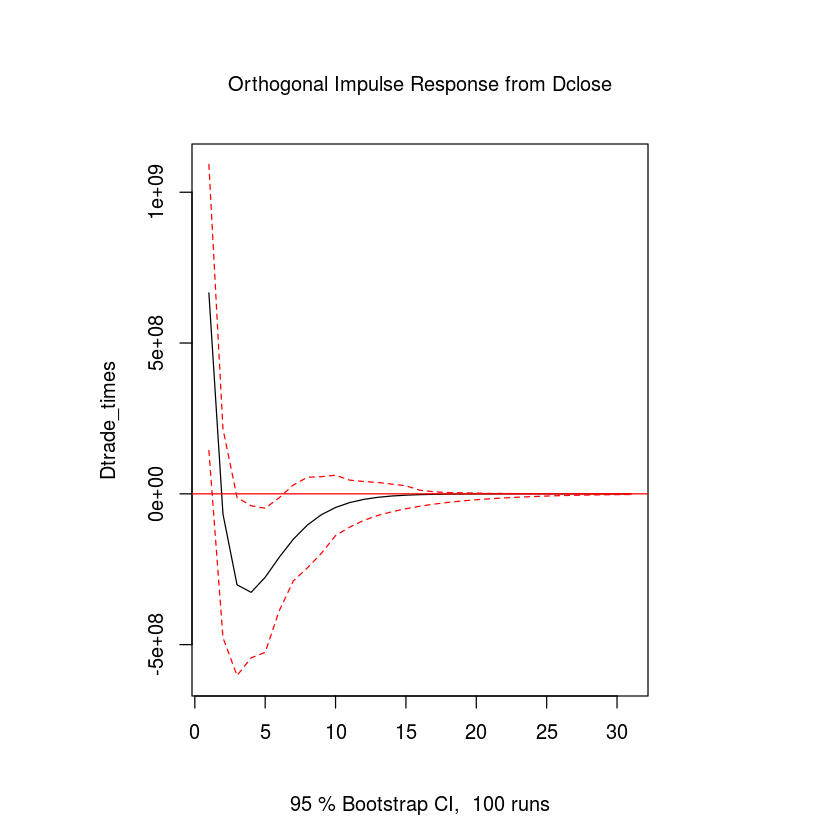

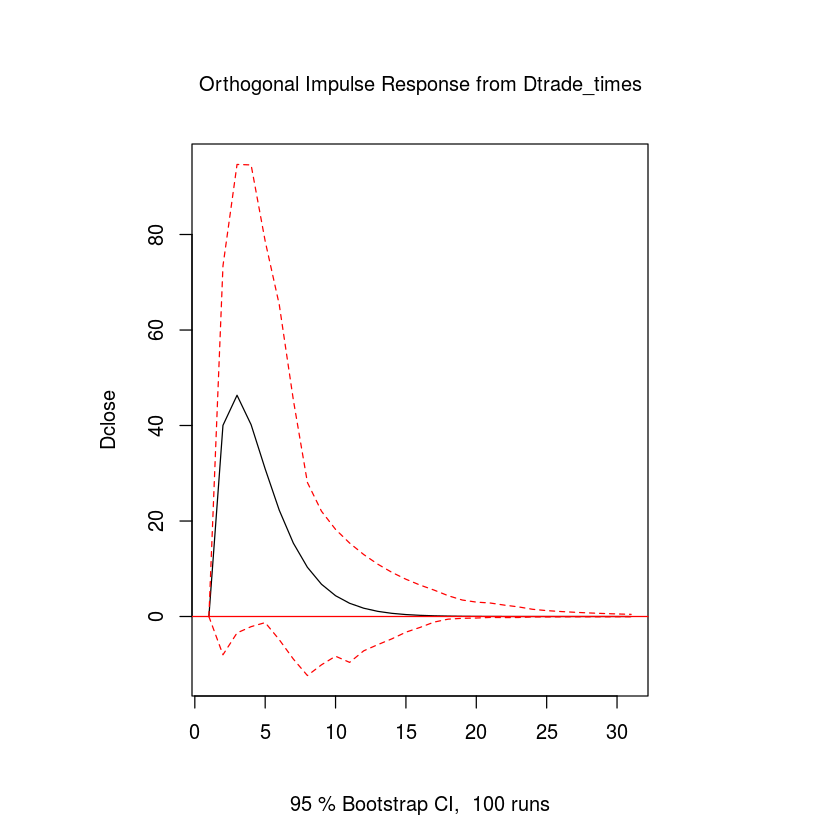

In [29]:
plot(irf(var.up, impulse="Dclose", response="Dtrade_times", boot=T, run=100, n.ahead=30))
plot(irf(var.up, impulse="Dtrade_times", response="Dclose",n.ahead = 30))

In [21]:
# 紧缩期间
sg.data.down <- sg.data[sg.data$year>=2011, ]
sg.data.down <- subset(sg.data.down, select = c("Dclose", "Dtrade_times"))
VARselect(sg.data.down, lag.max=2, type='const')

,1,2
AIC(n),5.427113e+01,5.466279e+01
HQ(n),5.424577e+01,5.462053e+01
SC(n),5.454501e+01,5.511926e+01
FPE(n),3.762795e+23,5.866097e+23


In [22]:
var.down <- VAR(sg.data.down, p=1, type = "const")
# names(var.down)
summary(var.down)
# plot(var.down)
# causality(var.down, cause = "close")$Granger
# causality(var.down, cause = "trade_times")$Granger


VAR Estimation Results:
Endogenous variables: Dclose, Dtrade_times 
Deterministic variables: const 
Sample size: 15 
Log Likelihood: -443.587 
Roots of the characteristic polynomial:
0.8497 0.106
Call:
VAR(y = sg.data.down, p = 1, type = "const")


Estimation results for equation Dclose: 
Dclose = Dclose.l1 + Dtrade_times.l1 + const 

                  Estimate Std. Error t value Pr(>|t|)  
Dclose.l1       -2.623e-01  3.894e-01  -0.674   0.5134  
Dtrade_times.l1  4.509e-08  1.789e-08   2.521   0.0269 *
const           -3.342e+01  4.519e+01  -0.739   0.4739  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Residual standard error: 156.7 on 12 degrees of freedom
Multiple R-Squared: 0.3887,	Adjusted R-squared: 0.2868 
F-statistic: 3.815 on 2 and 12 DF,  p-value: 0.0522 


Estimation results for equation Dtrade_times: 
Dtrade_times = Dclose.l1 + Dtrade_times.l1 + const 

                  Estimate Std. Error t value Pr(>|t|)
Dclose.l1       -3.853e+06  1.237e+07  -0.3

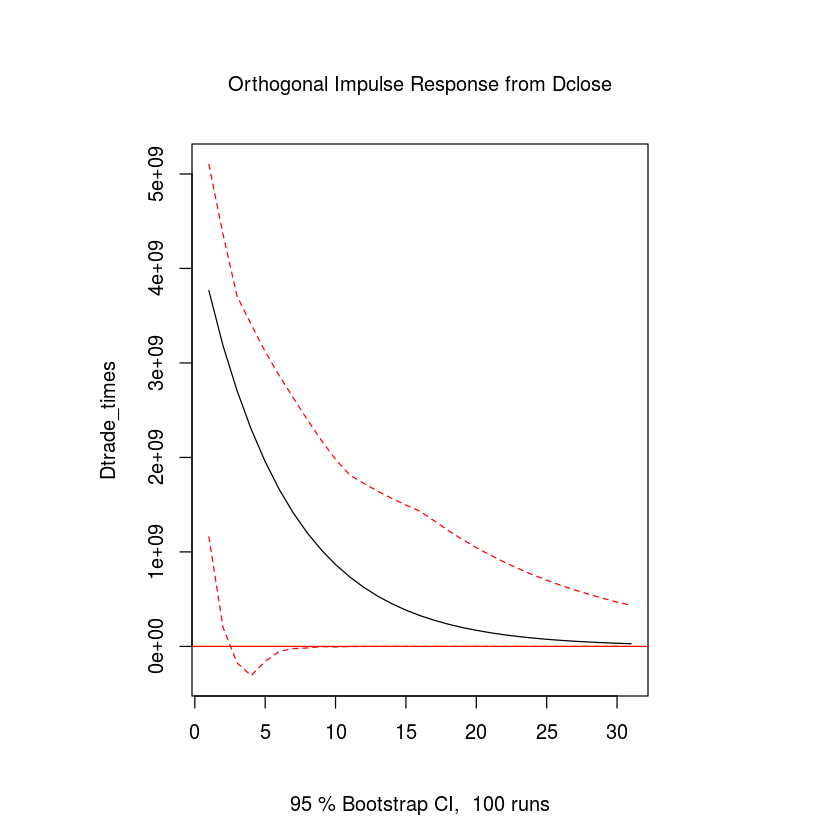

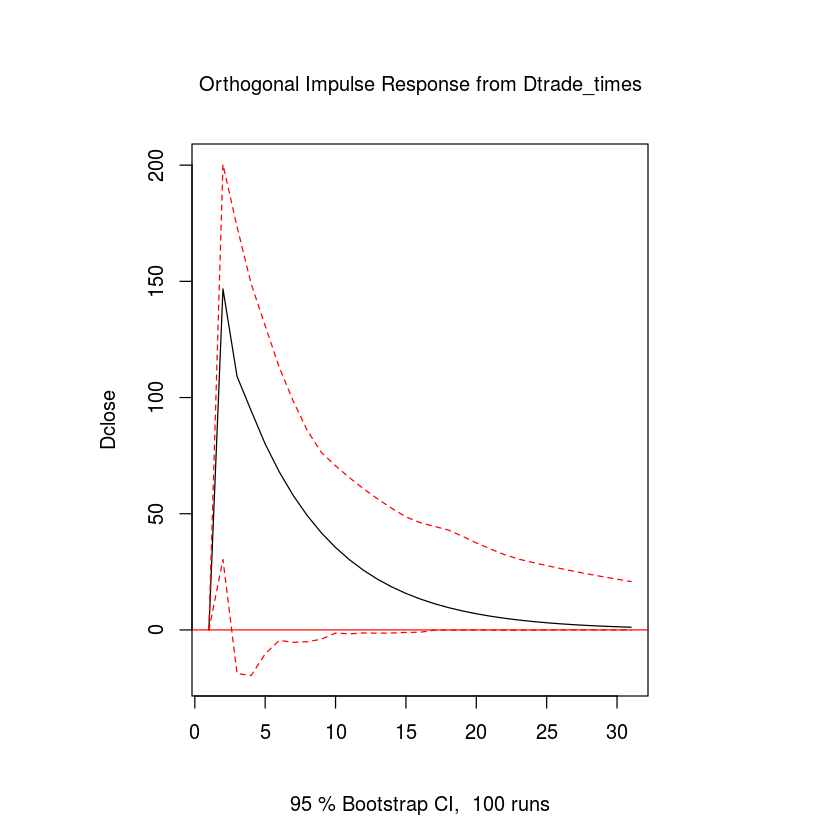

In [24]:
plot(irf(var.down, impulse="Dclose", response="Dtrade_times", n.ahead = 30)) 
plot(irf(var.down, impulse="Dtrade_times", response="Dclose", n.ahead = 30))

In [25]:
# 变革期
sg.data.chg <- sg.data[(sg.data$year>2007)&(sg.data$year<=2010), ]
# head(sg.data.chg)
sg.data.chg <- subset(sg.data.chg, select = c("Dclose", "Dtrade_times"))
VARselect(sg.data.chg, lag.max=2, type='const')

,1,2
AIC(n),5.300477e+01,5.274753e+01
HQ(n),5.280561e+01,5.241559e+01
SC(n),5.318633e+01,5.305011e+01
FPE(n),1.086972e+23,9.854039e+22


In [26]:
var.chg <- VAR(sg.data.chg, p=2, type = "const")

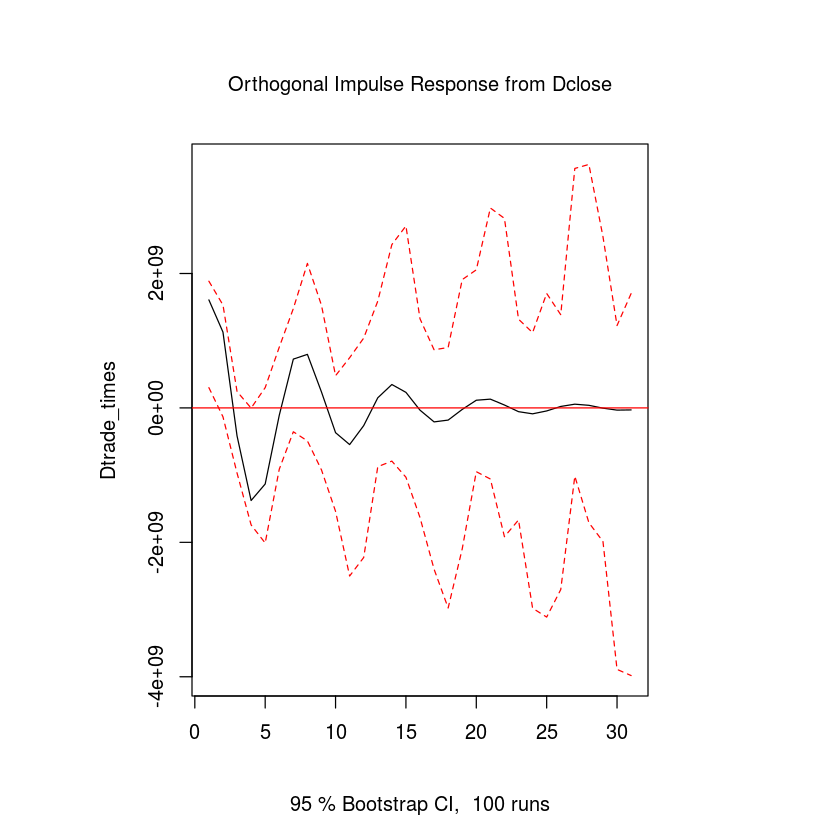

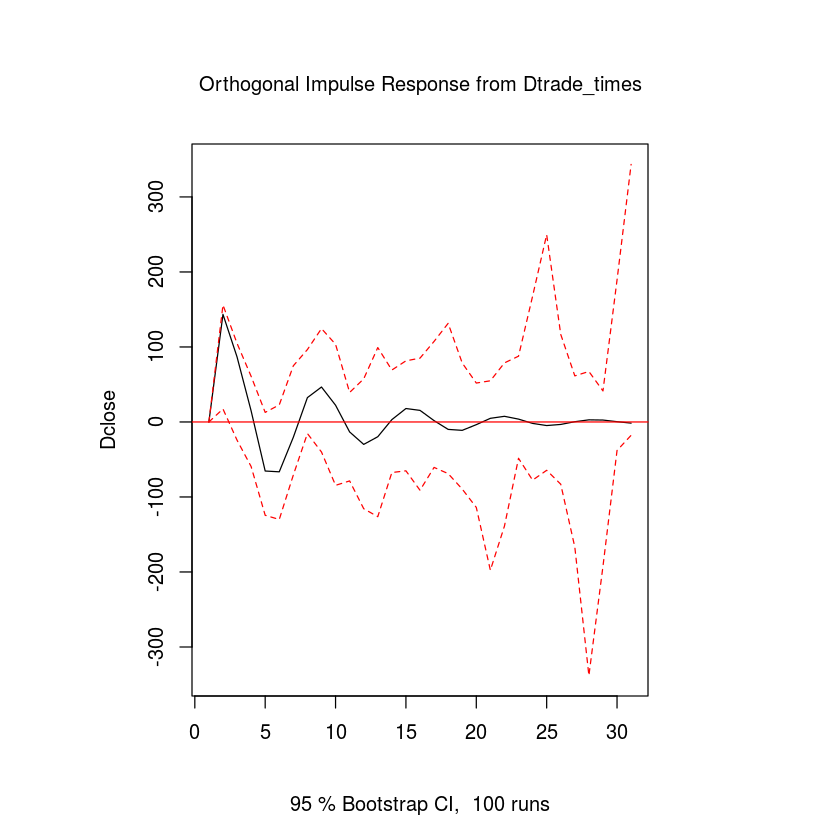

In [27]:
plot(irf(var.chg, impulse="Dclose", response="Dtrade_times", n.ahead = 30)) 
plot(irf(var.chg, impulse="Dtrade_times", response="Dclose", n.ahead = 30))